In [1]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
def visualize(results_df: pd.DataFrame):
    total_observations = len(results_df.subject.unique())
    res_df = results_df.copy()
    res_df["total_dice_loss"] = 1 - res_df["total_dice"]
    res_df["array_yield_loss"] = 1 - res_df["array_yield"]
    dvs = ["cost", "total_dice_loss", "array_yield_loss", "total_HD"]
    dv_names = ["Cost", "Dice loss (1-dice)", "Yield loss (1-yield)", "Hellinger distance"]
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharex=True)
    for i, dv in enumerate(dvs):
        sns.pointplot(x="array", y=dv, hue="hemisphere", data=res_df, ax=axes[i])
        axes[i].set_title(f"Cumulative {dv_names[i].lower()}", fontsize=16)
        axes[i].set_xlabel("", fontsize=16)
        axes[i].set_ylabel(dv_names[i], fontsize=16)
        axes[i].legend(title="Hemisphere")
    fig.suptitle(f"Mean cumulative losses", fontsize=24) #based on a total of {total_observations}
    fig.supxlabel("Array", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"./losses.png")
    plt.show()

In [3]:
def get_data_hem(max_arrays: int):
    """        
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe to be put in the AnovaRM function with columns:
        ["subject", "hemisphere", "array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """

    results_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"   
    sub_list = os.listdir(results_path)
    out_df = pd.DataFrame()
    arrays = [i for i in range(1, max_arrays + 1)]
    for sub in sub_list:
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
        # hem_df = pd.DataFrame()
        # both_hems = 0
        for hem in ["LH", "RH"]:
            hem_dir = os.path.join(results_path, sub, hem)
            filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
            # Assuming there's only one file in the directory, you can take the first one
            filename = [file for file in filenames if "best" in file][0]
            try:
                res_df = pd.read_csv(filename)
                columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                max_array_exists = arrays[-1] in res_df["array"].tolist()
                if max_array_exists:
                    # both_hems += 1
                    for array in arrays:
                        arr_row = res_df[res_df["array"] == array]
                        selected_columns = arr_row[columns_to_select].copy()
                        selected_columns["subject"] = sub
                        selected_columns["hemisphere"] = hem
                        column_order = ["subject", "hemisphere", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                        selected_columns = selected_columns[column_order]
                        out_df = pd.concat([out_df, selected_columns], ignore_index=True)
                # if both_hems == 2:
                #     out_df = pd.concat((out_df, hem_df), ignore_index=True)
            except FileNotFoundError as e:
                print(f"File {filename} not found")
                continue

    return out_df

In [4]:
def get_data(max_arrays: int):
    """        
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe to be put in the AnovaRM function with columns:
        ["subject", "hemisphere", "array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """

    results_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"   
    sub_list = os.listdir(results_path)
    out_df = pd.DataFrame()
    arrays = [i for i in range(1, max_arrays + 1)]
    for sub in sub_list:
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
        hem_df = pd.DataFrame()
        both_hems = 0
        for hem in ["LH", "RH"]:
            hem_dir = os.path.join(results_path, sub, hem)
            filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
            # Assuming there's only one file in the directory, you can take the first one
            filename = [file for file in filenames if "best" in file][0]
            try:
                res_df = pd.read_csv(filename)
                columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                max_array_exists = arrays[-1] in res_df["array"].tolist()
                if max_array_exists:
                    both_hems += 1
                    for array in arrays:
                        arr_row = res_df[res_df["array"] == array]
                        selected_columns = arr_row[columns_to_select].copy()
                        selected_columns["subject"] = sub
                        selected_columns["hemisphere"] = hem
                        column_order = ["subject", "hemisphere", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                        selected_columns = selected_columns[column_order]
                        hem_df = pd.concat([hem_df, selected_columns], ignore_index=True)
                if both_hems == 2:
                    out_df = pd.concat((out_df, hem_df), ignore_index=True)
            except FileNotFoundError as e:
                print(f"File {filename} not found")
                continue

    return out_df

In [5]:
# these only have the subs that have completed max array in BOTH hemispheres
array1_data = get_data(max_arrays=1)
array2_data = get_data(max_arrays=2)
array3_data = get_data(max_arrays=3)
array4_data = get_data(max_arrays=4)
all_arrays_data = get_data(max_arrays=5)
list_all_array_dfs = [array1_data, array2_data, array3_data, array4_data, all_arrays_data]

In [6]:
# these can have different number of subs for each max array per hemisphere
hem_array1_data = get_data_hem(max_arrays=1)
hem_array2_data = get_data_hem(max_arrays=2)
hem_array3_data = get_data_hem(max_arrays=3)
hem_array4_data = get_data_hem(max_arrays=4)
all_hem_arrays_data = get_data_hem(max_arrays=5)
list_all_hem_array_dfs = [hem_array1_data, hem_array2_data, hem_array3_data, hem_array4_data, all_hem_arrays_data]

In [7]:
def get_descriptive_stats(all_arrays_df: list, hem: str):
    descriptive_stats_df = pd.DataFrame()
    for df in all_arrays_df:
        hem_df = df[df["hemisphere"] == hem]
        max_array = hem_df.array.max()
        total_subs = len(hem_df.subject.unique())
        stats = hem_df.groupby(["hemisphere", "array"])[["total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]].mean().reset_index()
        stats = stats[stats["array"] == max_array].reset_index(drop=True)
        stats["total_subjects"] = total_subs
        stats["total_dice_loss"] = 1 - stats["total_dice"]
        stats["array_yield_loss"] = 1 - stats["array_yield"]
        column_order = ["array", "total_subjects", "hemisphere",  "total_dice_loss", "prop_total_dice", "array_yield_loss", "total_HD", "prop_total_hd", "cost", "prop_cost"]
        stats = stats[column_order]
        descriptive_stats_df = pd.concat([descriptive_stats_df, stats], ignore_index=True)
    
    return descriptive_stats_df

In [8]:
descriptives_LH = get_descriptive_stats(list_all_array_dfs, "LH")
descriptives_RH = get_descriptive_stats(list_all_array_dfs, "RH")

In [57]:
descriptives_LH

,array,total_subjects,hemisphere,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,181,LH,0.708030,0.394406,0.524133,0.826303,0.561050,2.510539,0.312013
1,2,181,LH,0.671418,0.443552,0.475912,0.811900,0.607056,2.457114,0.346110
2,3,181,LH,0.660305,0.458605,0.592713,0.808283,0.618783,2.448224,0.351778
3,4,157,LH,0.642033,0.481899,0.606917,0.801703,0.636496,2.424082,0.367274
4,5,76,LH,0.621118,0.503524,0.605211,0.793959,0.651611,2.395338,0.386746


In [58]:
descriptives_RH

,array,total_subjects,hemisphere,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,181,RH,0.598434,0.497316,0.568757,0.783563,0.596233,2.360434,0.410679
1,2,181,RH,0.546032,0.561860,0.477409,0.760097,0.659842,2.280000,0.462318
2,3,181,RH,0.535981,0.574189,0.594055,0.756795,0.668665,2.272479,0.467163
3,4,157,RH,0.527585,0.581934,0.610038,0.753362,0.671635,2.261449,0.474265
4,5,76,RH,0.505101,0.599879,0.642724,0.743515,0.675662,2.230752,0.494369


In [59]:
descriptives_hem_LH = get_descriptive_stats(list_all_hem_array_dfs, "LH")
descriptives_hem_RH = get_descriptive_stats(list_all_hem_array_dfs, "RH")

In [71]:
round(descriptives_hem_LH, 2)

,array,total_subjects,hemisphere,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,181,LH,0.71,0.39,0.52,0.83,0.56,2.51,0.31
1,2,181,LH,0.67,0.44,0.48,0.81,0.61,2.46,0.35
2,3,181,LH,0.66,0.46,0.59,0.81,0.62,2.45,0.35
3,4,164,LH,0.64,0.48,0.61,0.80,0.64,2.42,0.37
4,5,116,LH,0.63,0.50,0.60,0.80,0.65,2.40,0.38


In [70]:
round(descriptives_hem_RH, 2)

,array,total_subjects,hemisphere,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,181,RH,0.60,0.50,0.57,0.78,0.60,2.36,0.41
1,2,181,RH,0.55,0.56,0.48,0.76,0.66,2.28,0.46
2,3,181,RH,0.54,0.57,0.59,0.76,0.67,2.27,0.47
3,4,170,RH,0.53,0.58,0.61,0.75,0.67,2.26,0.47
4,5,106,RH,0.50,0.60,0.64,0.74,0.69,2.23,0.49


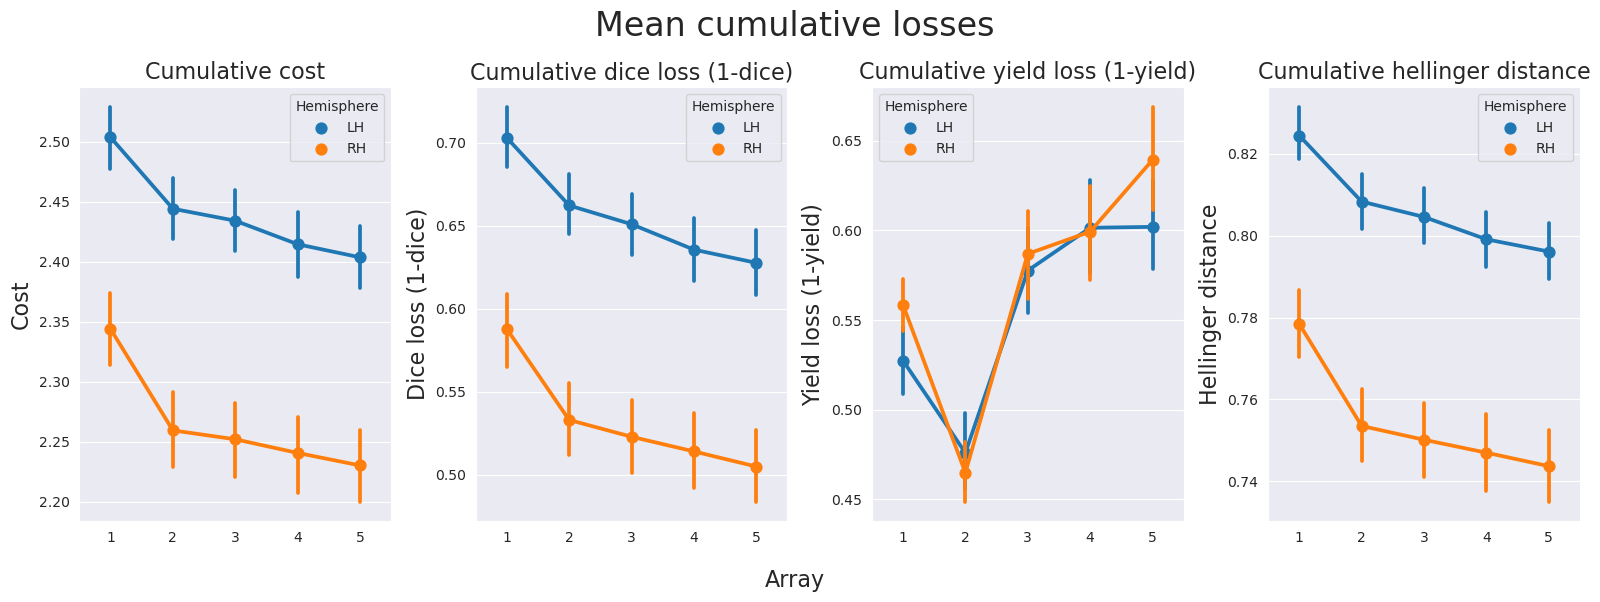

In [9]:
visualize(all_hem_arrays_data)

In [38]:
arr_df = all_arrays_data[(all_arrays_data["array"] == 2) & (all_arrays_data["hemisphere"] == "LH")].reset_index(drop=True)
cost_std = arr_df["cost"].std()
arr_df["std_cost"] = (arr_df["cost"] - arr_df["cost"].mean()) / cost_std
arr_df

,subject,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost,std_cost
0,114823,LH,2,0.221360,0.283309,0.561,0.841391,0.463785,2.591980,0.261442,0.973471
1,732243,LH,2,0.357632,0.508746,0.383,0.805219,0.704967,2.428438,0.363282,-0.092652
2,214524,LH,2,0.409894,0.547156,0.518,0.773772,0.718062,2.337977,0.422770,-0.682355
3,195041,LH,2,0.427411,0.572953,0.645,0.774273,0.690861,2.314613,0.433582,-0.834668
4,397760,LH,2,0.325376,0.435077,0.514,0.822412,0.597433,2.471336,0.341207,0.186998
...,...,...,...,...,...,...,...,...,...,...,...
71,547046,LH,2,0.380847,0.497291,0.494,0.792888,0.629206,2.387341,0.391896,-0.360559
72,826353,LH,2,0.433022,0.610491,0.560,0.778476,0.739652,2.317455,0.429221,-0.816141
73,782561,LH,2,0.210244,0.298946,0.496,0.859348,0.476256,2.624304,0.235983,1.184189
74,178647,LH,2,0.331508,0.454942,0.426,0.811862,0.640600,2.459054,0.345650,0.106935


In [73]:
all_hem_arrays_data_LH = all_hem_arrays_data[all_hem_arrays_data["hemisphere"] == "LH"]
all_hem_arrays_data_RH = all_hem_arrays_data[all_hem_arrays_data["hemisphere"] == "RH"]

In [75]:
def create_histograms(all_arrays_data_LH, all_arrays_data_RH):
    row = 0
    col = 0
    colors = ["green", "skyblue", "olive", "gold", "teal"]
    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    for hem, df in zip(["left", "right"], [all_arrays_data_LH, all_arrays_data_RH]):
        for arr in range(1, 6):
            arr_df = df[df["array"] == arr].reset_index(drop=True).copy()
            sns.histplot(data=arr_df, x="cost", kde=False, color=colors[col], ax=axes[row, col])
            axes[row, col].set_xlabel(f"Cost for array {arr}", fontsize=14) if row == 1 else axes[row, col].set_xlabel("")
            axes[row, col].set_ylabel("")
            col += 1
        row += 1
        col = 0
    
    labels = ["Count for left hemisphere", "Count for right hemisphere"]
    for l, ax in zip(labels, axes):
        ax[0].set_ylabel(l, fontsize=14)
        
    fig.suptitle(f"Distribution of cost per array and hemisphere", fontsize=24)
    plt.tight_layout()
    plt.savefig(f"./histograms.png")
    plt.show()

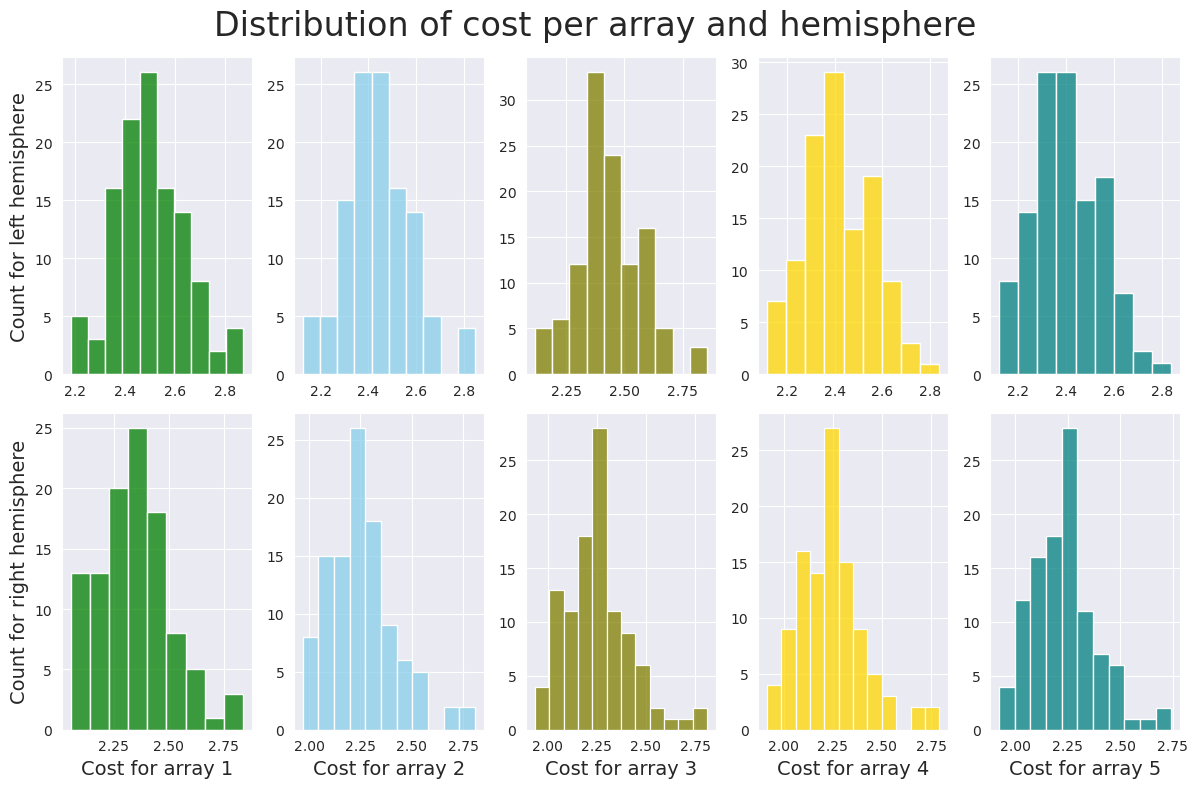

In [76]:
create_histograms(all_hem_arrays_data_LH, all_hem_arrays_data_RH)

In [68]:
for arr in range(1, 6):
    for arr_next in range(arr+1, 6):
        arr_df_first = all_hem_arrays_data_LH[all_hem_arrays_data_LH["array"] == arr].reset_index(drop=True)
        arr_df_second = all_hem_arrays_data_LH[all_hem_arrays_data_LH["array"] == arr_next].reset_index(drop=True)
        
        arr_df_second["dif"] = arr_df_first["cost"] - arr_df_second["cost"]
        dif_std = arr_df_second["dif"].std()
        
        print("Array pair:", arr, arr_next)
        print("mean dif and srd:", round(arr_df_second["dif"].mean(), 4), round(dif_std, 4))

Array pair: 1 2
mean dif and srd: 0.0596 0.037
Array pair: 1 3
mean dif and srd: 0.0696 0.0551
Array pair: 1 4
mean dif and srd: 0.0892 0.0835
Array pair: 1 5
mean dif and srd: 0.1001 0.0851
Array pair: 2 3
mean dif and srd: 0.01 0.035
Array pair: 2 4
mean dif and srd: 0.0296 0.0786
Array pair: 2 5
mean dif and srd: 0.0405 0.0806
Array pair: 3 4
mean dif and srd: 0.0196 0.0743
Array pair: 3 5
mean dif and srd: 0.0305 0.0783
Array pair: 4 5
mean dif and srd: 0.0109 0.0293


In [69]:
for arr in range(1, 6):
    for arr_next in range(arr+1, 6):
        arr_df_first = all_hem_arrays_data_RH[all_hem_arrays_data_RH["array"] == arr].reset_index(drop=True)
        arr_df_second = all_hem_arrays_data_RH[all_hem_arrays_data_RH["array"] == arr_next].reset_index(drop=True)
        
        arr_df_second["dif"] = arr_df_first["cost"] - arr_df_second["cost"]
        dif_std = arr_df_second["dif"].std()
        
        print("Array pair:", arr, arr_next)
        print("mean dif and srd:", round(arr_df_second["dif"].mean(), 4), round(dif_std, 4))

Array pair: 1 2
mean dif and srd: 0.0846 0.047
Array pair: 1 3
mean dif and srd: 0.092 0.0641
Array pair: 1 4
mean dif and srd: 0.1034 0.0707
Array pair: 1 5
mean dif and srd: 0.1138 0.0777
Array pair: 2 3
mean dif and srd: 0.0074 0.0249
Array pair: 2 4
mean dif and srd: 0.0188 0.0401
Array pair: 2 5
mean dif and srd: 0.0292 0.056
Array pair: 3 4
mean dif and srd: 0.0114 0.0318
Array pair: 3 5
mean dif and srd: 0.0218 0.0515
Array pair: 4 5
mean dif and srd: 0.0104 0.0408


In [66]:
def post_hoc_comparisons(array_hem_data: pd.DataFrame):
    """Runs all post-hoc comparisons with Tukey's pairwise test.
    This inherently corrects for multiple comparisons, thus
    keeping the family-wise error rate at the specified alpha.
    
    The comparisons are done for the specified hemisphere.
    
    Parameters
    ----------
    array_data : pd.DataFrame
        The dataframe with the results data for one hemisphere.
        Columns: ["subject", "hemisphere", "array", "total_dice", "total_yield", "total_HD", "cost"]

    Returns
    -------
    results : A TukeyHSDResults instance
    """
    results = pairwise_tukeyhsd(endog=array_hem_data[["cost"]],
                                groups=array_hem_data[["array"]], alpha=0.05)
    
    return results

for hem in ["LH", "RH"]:
    hem_df = all_hem_arrays_data[all_hem_arrays_data["hemisphere"] == hem]
    total_observations = len(hem_df.subject.unique())
    print(f"COMPARISONS FOR {hem}, AND A TOTAL OF 5 ARRAYS WITH {total_observations} SUBJECTS:")
    print(post_hoc_comparisons(hem_df).summary())
    print("*"*52, "\n")

COMPARISONS FOR LH, AND A TOTAL OF 5 ARRAYS WITH 116 SUBJECTS:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0596 0.0117 -0.1102  -0.009   True
     1      3  -0.0696 0.0017 -0.1202  -0.019   True
     1      4  -0.0892    0.0 -0.1398 -0.0386   True
     1      5  -0.1001    0.0 -0.1507 -0.0495   True
     2      3    -0.01 0.9831 -0.0606  0.0406  False
     2      4  -0.0296  0.498 -0.0802   0.021  False
     2      5  -0.0405 0.1847 -0.0911  0.0101  False
     3      4  -0.0196  0.827 -0.0702   0.031  False
     3      5  -0.0305 0.4658 -0.0811  0.0201  False
     4      5  -0.0109 0.9765 -0.0615  0.0397  False
----------------------------------------------------
**************************************************** 

COMPARISONS FOR RH, AND A TOTAL OF 5 ARRAYS WITH 106 SUBJECTS:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p

In [72]:
import pingouin as pg

s_LH = pg.sphericity(data=all_hem_arrays_data_LH, dv="cost", subject="subject", within="array")
s_RH = pg.sphericity(data=all_hem_arrays_data_RH, dv="cost", subject="subject", within="array")

# p val should be > 0.05
print(s_LH)
print(s_RH)

# Homogeneity of variances
homogeneity_test_LH = pg.homoscedasticity(all_hem_arrays_data_LH, dv="cost", group="array")
homogeneity_test_RH = pg.homoscedasticity(all_hem_arrays_data_RH, dv="cost", group="array")
print("Homogeneity of variances LH:\n", homogeneity_test_LH)
print("Homogeneity of variances RH:\n", homogeneity_test_RH)

SpherResults(spher=True, W=558260.0119462569, chi2=-1500.7951268024128, dof=9, pval=1.0)
SpherResults(spher=True, W=2066866.3247224041, chi2=-1503.8380257735967, dof=9, pval=1.0)
Homogeneity of variances LH:
                W      pval  equal_var
levene  0.095355  0.983927       True
Homogeneity of variances RH:
                W      pval  equal_var
levene  0.129786  0.971538       True


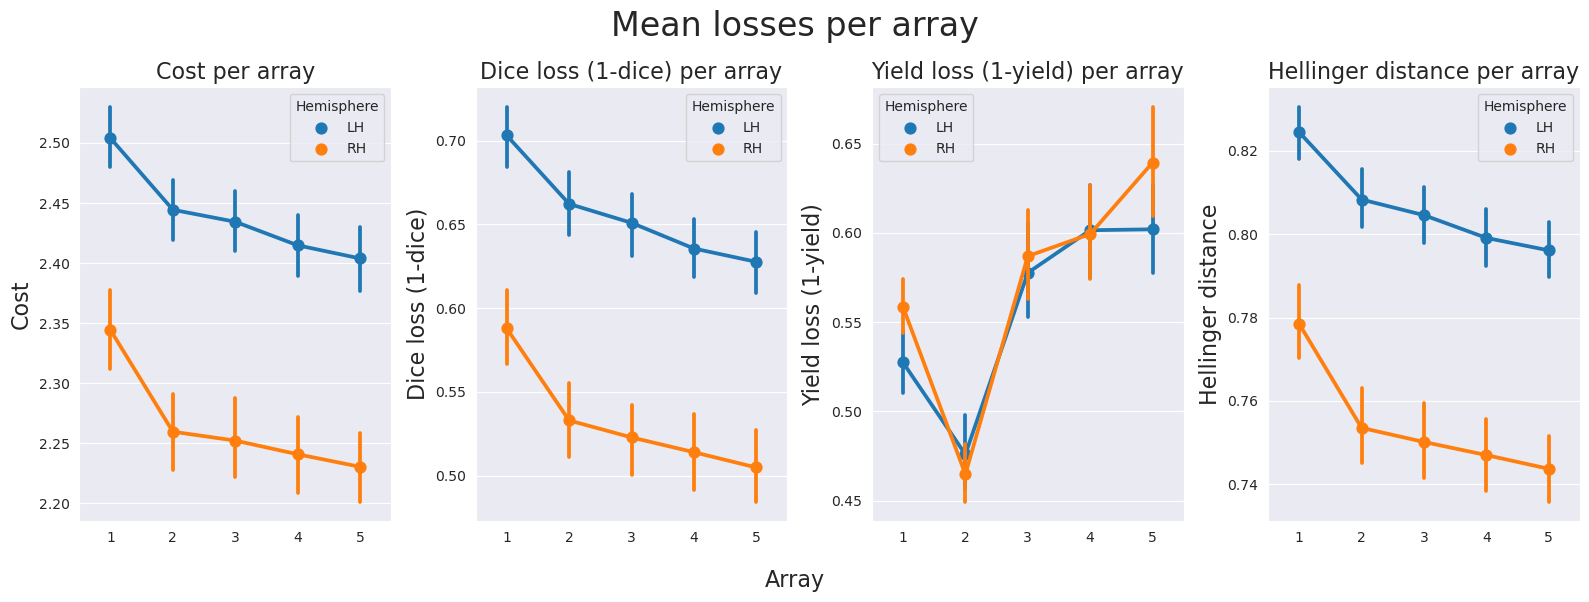

In [33]:
visualize(all_arrays_data)

In [29]:
len(all_hem_arrays_data_LH.subject.unique())

116

In [30]:
len(all_hem_arrays_data_RH.subject.unique())

106

In [31]:
all_hem_arrays_data_LH

,subject,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,LH,2,0.221360,0.283309,0.561,0.841391,0.463785,2.591980,0.261442
2,114823,LH,3,0.222758,0.285098,0.296,0.840785,0.465556,2.603227,0.254236
3,114823,LH,4,0.223341,0.285844,0.288,0.840519,0.466333,2.602778,0.254523
4,114823,LH,5,0.232503,0.297570,0.327,0.835550,0.480864,2.586696,0.264828
...,...,...,...,...,...,...,...,...,...,...
1100,463040,LH,1,0.176829,0.229721,0.519,0.859602,0.435642,2.656823,0.221045
1101,463040,LH,2,0.195422,0.253875,0.564,0.856551,0.445110,2.632929,0.236435
1102,463040,LH,3,0.201202,0.261383,0.600,0.859418,0.436214,2.628216,0.239471
1103,463040,LH,4,0.201202,0.261383,0.295,0.859410,0.436237,2.643459,0.229653


In [32]:
model_LH = AnovaRM(data=all_hem_arrays_data_LH, depvar="cost", subject="subject",
                    within=["array"]).fit()

model_RH = AnovaRM(data=all_hem_arrays_data_RH, depvar="cost", subject="subject", within=["array"]).fit()

print(model_LH.summary())
print(model_RH.summary())

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
array 78.3952 4.0000 460.0000 0.0000

                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
array 155.8899 4.0000 420.0000 0.0000



In [25]:
all_arrays_data_LH

,subject,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,LH,2,0.221360,0.283309,0.561,0.841391,0.463785,2.591980,0.261442
2,114823,LH,3,0.222758,0.285098,0.296,0.840785,0.465556,2.603227,0.254236
3,114823,LH,4,0.223341,0.285844,0.288,0.840519,0.466333,2.602778,0.254523
4,114823,LH,5,0.232503,0.297570,0.327,0.835550,0.480864,2.586696,0.264828
...,...,...,...,...,...,...,...,...,...,...
375,463040,LH,1,0.176829,0.229721,0.519,0.859602,0.435642,2.656823,0.221045
376,463040,LH,2,0.195422,0.253875,0.564,0.856551,0.445110,2.632929,0.236435
377,463040,LH,3,0.201202,0.261383,0.600,0.859418,0.436214,2.628216,0.239471
378,463040,LH,4,0.201202,0.261383,0.295,0.859410,0.436237,2.643459,0.229653


In [24]:
model_LH = AnovaRM(data=all_arrays_data_LH, depvar="cost", subject="subject",
                    within=["array"]).fit()

model_RH = AnovaRM(data=all_arrays_data_RH, depvar="cost", subject="subject", within=["array"]).fit()

print(model_LH.summary())
print(model_RH.summary())

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
array 48.8042 4.0000 300.0000 0.0000

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
array 96.8569 4.0000 300.0000 0.0000



In [105]:
model = AnovaRM(data=all_arrays_data, depvar="cost", subject="subject", within=["array", "hemisphere"]).fit()

model.summary()

,F Value,Num DF,Den DF,Pr > F
array,126.9500,4.0000,300.0000,0.0000
hemisphere,68.6749,1.0000,75.0000,0.0000
array:hemisphere,1.4812,4.0000,300.0000,0.2078


In [86]:
from bioinfokit.analys import stat

"""p needs to be > 0.05 to reject the null, and to infer equal variances"""
res = stat()
res.levene(df=all_arrays_data, res_var="cost", xfac_var="array")
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.1107
1,Degrees of freedom (Df),4.0000
2,p value,0.9788


In [90]:
model = AnovaRM(data=all_arrays_data, depvar="cost", subject="subject",
                    within=["array", "hemisphere"]).fit()
model.summary()

,F Value,Num DF,Den DF,Pr > F
array,126.9500,4.0000,300.0000,0.0000
hemisphere,68.6749,1.0000,75.0000,0.0000
array:hemisphere,1.4812,4.0000,300.0000,0.2078


In [93]:
def run_rm_anova(array_data: pd.DataFrame):
    """Runs a repeated measures anova for the given data.
    
    Parameters
    ----------
    array_data : pd.DataFrame
        The dataframe with the results data.
        Columns: ["subject", "hemisphere", "array", "total_dice", "total_yield", "total_HD", "cost"]

    Returns
    -------
    model : An AnovaRM instance
    """
    model = AnovaRM(data=array_data, depvar="cost", subject="subject",
                    within=["hemisphere", "array"]).fit()
    
    return model

for i, array_data in enumerate([array2_data, array3_data, array4_data, all_arrays_data]):
    total_observations = len(array_data.subject.unique())
    print(f"RM ANOVA FOR A TOTAL OF {i+2} ARRAYS WITH {total_observations} SUBJECTS:")
    print(run_rm_anova(array_data).summary())
    print("*"*52, "\n")

RM ANOVA FOR A TOTAL OF 2 ARRAYS WITH 181 SUBJECTS:
                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
hemisphere        162.1862 1.0000 180.0000 0.0000
array            1004.2900 1.0000 180.0000 0.0000
hemisphere:array   44.7828 1.0000 180.0000 0.0000

**************************************************** 

RM ANOVA FOR A TOTAL OF 3 ARRAYS WITH 181 SUBJECTS:
                     Anova
                 F Value  Num DF  Den DF  Pr > F
------------------------------------------------
hemisphere       169.9249 1.0000 180.0000 0.0000
array            588.3951 2.0000 360.0000 0.0000
hemisphere:array  21.2568 2.0000 360.0000 0.0000

**************************************************** 

RM ANOVA FOR A TOTAL OF 4 ARRAYS WITH 157 SUBJECTS:
                     Anova
                 F Value  Num DF  Den DF  Pr > F
------------------------------------------------
hemisphere       145.8199 1.0000 156.0000 0.0000
array   

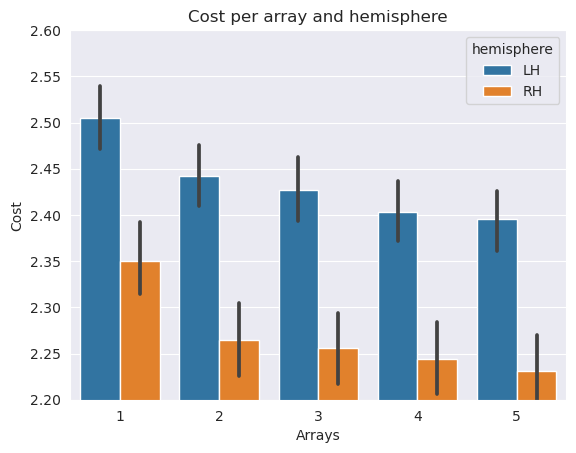

In [16]:
# Plotting
sns.barplot(data=all_arrays_data, x="array", y="cost", hue="hemisphere")

# Adding labels and title
plt.xlabel("Arrays")
plt.ylabel("Cost")
plt.ylim(2.2, 2.6)
plt.title("Cost per array and hemisphere")
plt.show()

In [ ]:
"""A significant interaction between hemisphere:array means that the impact of hemisphere changes depending on the array.

A non-significant interaction between hemisphere:array suggests that the impact of the hemisphere remains the same across arrays. The effect of one factor (hemisphere) is consistent across different levels of the other factor (array). This suggests that the factors are independent in terms of their effect on the outcome variable (the cost)!"""